# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

====================================================================================================================================================

El objetivo es averiguar si hay diferencias significativas entre los ingresos de los planes `Surf` y `Ultimate` así como ver si el comportamiento del área de `NY-NJ` es parecido al resto de los datos recolectados o diferente.

Para eso se necesitará hacer un procesamiento de los datos, hacer gráficos y sacar medidas estadísticas para dar una intuición del comportamiento de los datos, y al final aplicar varias pruebas estadísticas para comprobar si las diferencias entre los distintos grupos (`Surf-Ultimate` y `NYNJ-resto`) son lo suficientemente significativas o se comportan de manera parecida.

## Inicialización

In [1]:
# Cargar todas las librerías
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as st

### Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

df_calls = pd.read_csv("datasets/megaline_calls.csv")
df_internet = pd.read_csv("datasets/megaline_internet.csv")
df_messages = pd.read_csv("datasets/megaline_messages.csv")
df_plans = pd.read_csv("datasets/megaline_plans.csv")
df_users = pd.read_csv("datasets/megaline_users.csv")

## Preparar los datos

### Tarifas (Listo)

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas

df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Aquí vemos la descripción de los planes, la información está completa

#### Corregir datos

No hay problemas obvios con los datos. 

#### Enriquecer los datos

En mi opinión, no hay nada que enriquecer

### Usuarios/as

In [5]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Imprime una muestra de datos para usuarios

df_users.sample(10,random_state=42)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaN
73,1073,Grady,Crawford,30,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-06,surf,NaN
374,1374,Ching,Watts,55,"Louisville/Jefferson County, KY-IN MSA",2018-02-14,surf,NaN
155,1155,Claude,Hahn,19,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-02-21,ultimate,NaN
104,1104,Thurman,Stephens,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-12-23,ultimate,NaN
394,1394,Alejandro,Carver,28,"Stockton, CA MSA",2018-01-16,surf,NaN
377,1377,Vallie,Conway,18,"Rochester, NY MSA",2018-03-27,surf,NaN
124,1124,Jenell,Navarro,48,"New Haven-Milford, CT MSA",2018-02-19,ultimate,NaN
68,1068,Marcel,Jimenez,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-29,surf,NaN
450,1450,Errol,Marquez,67,"Bakersfield, CA MSA",2018-06-16,ultimate,NaN


- Tenemos datos nulos en `churn_date`, pero está bien que haya nulos ya que eso significa que el usuario sigue usando el servicio al momento de hacer el muestreo.
- `reg_date` es de tipo objeto, cuando nos serviría más como tipo datetime.
- Lo mismo con la columna `churn_date`.
- En la columna `city` tenemos la ciudad y el estado juntos, podríamos separarlos para tener la información más disponible.
- Podemos separar los años, meses y días de las columnas que contienen fechas.

#### Corregir los datos

In [7]:
#reg_date como datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])

In [8]:
#churn_date como datetime
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

In [9]:
#verificar el tipo de datos
df_users.dtypes

user_id                int64
first_name            object
last_name             object
age                    int64
city                  object
reg_date      datetime64[ns]
plan                  object
churn_date    datetime64[ns]
dtype: object

In [10]:
df_users.sample(10,random_state=42)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaT
73,1073,Grady,Crawford,30,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-06,surf,NaT
374,1374,Ching,Watts,55,"Louisville/Jefferson County, KY-IN MSA",2018-02-14,surf,NaT
155,1155,Claude,Hahn,19,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-02-21,ultimate,NaT
104,1104,Thurman,Stephens,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-12-23,ultimate,NaT
394,1394,Alejandro,Carver,28,"Stockton, CA MSA",2018-01-16,surf,NaT
377,1377,Vallie,Conway,18,"Rochester, NY MSA",2018-03-27,surf,NaT
124,1124,Jenell,Navarro,48,"New Haven-Milford, CT MSA",2018-02-19,ultimate,NaT
68,1068,Marcel,Jimenez,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-29,surf,NaT
450,1450,Errol,Marquez,67,"Bakersfield, CA MSA",2018-06-16,ultimate,NaT


#### Enriquecer los datos

In [11]:
#columna reg_date desglosada
df_users['reg_date_year'] = df_users['reg_date'].dt.year
df_users['reg_date_month'] = df_users['reg_date'].dt.month
df_users['reg_date_day'] = df_users['reg_date'].dt.day

In [12]:
#columna churn_date desglosada
df_users['churn_date_year'] = df_users['churn_date'].dt.year
df_users['churn_date_month'] = df_users['churn_date'].dt.month
df_users['churn_date_day'] = df_users['churn_date'].dt.day

In [13]:
df_users.sample(10,random_state=42)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_date_year,reg_date_month,reg_date_day,churn_date_year,churn_date_month,churn_date_day
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaT,2018,4,14,NaN,NaN,NaN
73,1073,Grady,Crawford,30,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-06,surf,NaT,2018,4,6,NaN,NaN,NaN
374,1374,Ching,Watts,55,"Louisville/Jefferson County, KY-IN MSA",2018-02-14,surf,NaT,2018,2,14,NaN,NaN,NaN
155,1155,Claude,Hahn,19,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-02-21,ultimate,NaT,2018,2,21,NaN,NaN,NaN
104,1104,Thurman,Stephens,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-12-23,ultimate,NaT,2018,12,23,NaN,NaN,NaN
394,1394,Alejandro,Carver,28,"Stockton, CA MSA",2018-01-16,surf,NaT,2018,1,16,NaN,NaN,NaN
377,1377,Vallie,Conway,18,"Rochester, NY MSA",2018-03-27,surf,NaT,2018,3,27,NaN,NaN,NaN
124,1124,Jenell,Navarro,48,"New Haven-Milford, CT MSA",2018-02-19,ultimate,NaT,2018,2,19,NaN,NaN,NaN
68,1068,Marcel,Jimenez,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-29,surf,NaT,2018,1,29,NaN,NaN,NaN
450,1450,Errol,Marquez,67,"Bakersfield, CA MSA",2018-06-16,ultimate,NaT,2018,6,16,NaN,NaN,NaN


### Llamadas

In [14]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Imprime una muestra de datos para las llamadas

df_calls.sample(10,random_state=42)

,id,user_id,call_date,duration
52288,1187_481,1187,2018-12-12,0.00
30634,1114_568,1114,2018-10-21,1.05
54228,1196_106,1196,2018-07-23,5.67
110372,1389_454,1389,2018-05-12,11.49
109600,1386_60,1386,2018-11-24,0.00
87094,1320_763,1320,2018-06-23,3.84
67527,1242_23,1242,2018-11-15,13.67
9557,1042_494,1042,2018-11-05,7.10
104970,1369_55,1369,2018-12-28,0.00
124419,1439_287,1439,2018-08-16,8.32


- Los id de la llamada tienen primero el id de usuario y luego el id de la llamada separados por un guión bajo, lo cual es una buena manera de registrar los id para asegurarse que no haya repetidos.
- La columna `call_date` tiene el mismo problema que las fechas en la tabla anterior, no está en formato datetime, y podemos desglosar esa información
- La columna `duration` nos dice que está en minutos. Según las instrucciones, las llamadas individuales se redondean al minuto más alto, por lo que podemos aplicarle la función `ceil` para solo conservar los minutos.
- No hay datos faltantes

#### Corregir los datos

In [16]:
#columna call_date a datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

In [17]:
df_calls.dtypes

id                   object
user_id               int64
call_date    datetime64[ns]
duration            float64
dtype: object

#### Enriquecer los datos

In [18]:
#desglosar la columna call_date
df_calls['year'] = df_calls['call_date'].dt.year
df_calls['month'] = df_calls['call_date'].dt.month
df_calls['day'] = df_calls['call_date'].dt.day

In [19]:
#redondear hacia arriba los minutos
df_calls['duration_rounded'] = df_calls['duration'].apply('ceil')
df_calls['duration_rounded'] = df_calls['duration_rounded'].astype('int')

In [20]:
df_calls.sample(10, random_state=42)

,id,user_id,call_date,duration,year,month,day,duration_rounded
52288,1187_481,1187,2018-12-12,0.00,2018,12,12,0
30634,1114_568,1114,2018-10-21,1.05,2018,10,21,2
54228,1196_106,1196,2018-07-23,5.67,2018,7,23,6
110372,1389_454,1389,2018-05-12,11.49,2018,5,12,12
109600,1386_60,1386,2018-11-24,0.00,2018,11,24,0
87094,1320_763,1320,2018-06-23,3.84,2018,6,23,4
67527,1242_23,1242,2018-11-15,13.67,2018,11,15,14
9557,1042_494,1042,2018-11-05,7.10,2018,11,5,8
104970,1369_55,1369,2018-12-28,0.00,2018,12,28,0
124419,1439_287,1439,2018-08-16,8.32,2018,8,16,9


In [21]:
df_calls.dtypes

id                          object
user_id                      int64
call_date           datetime64[ns]
duration                   float64
year                         int32
month                        int32
day                          int32
duration_rounded             int64
dtype: object

### Mensajes

In [22]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [23]:
# Imprime una muestra de datos para los mensajes

df_messages.sample(10, random_state=42)

,id,user_id,message_date
58331,1369_132,1369,2018-12-27
24196,1145_51,1145,2018-07-11
9284,1069_42,1069,2018-12-03
44214,1293_1181,1293,2018-10-06
57006,1362_72,1362,2018-05-25
65485,1421_70,1421,2018-12-21
10405,1076_916,1076,2018-11-23
36070,1237_91,1237,2018-09-02
31581,1196_64,1196,2018-06-27
15257,1101_314,1101,2018-12-16


- Es muy similar a la tabla de `calls`, solo que no tiene la columna de duración.
- Lo unico que podríamos cambiar es `message_date` transformarla a datetime, y desglosarla
- No hay valores ausentes

#### Corregir los datos

In [24]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

#### Enriquecer los datos

In [25]:
df_messages['year'] = df_messages['message_date'].dt.year
df_messages['month'] = df_messages['message_date'].dt.month
df_messages['day'] = df_messages['message_date'].dt.day

In [26]:
df_messages.sample(10, random_state=42)

,id,user_id,message_date,year,month,day
58331,1369_132,1369,2018-12-27,2018,12,27
24196,1145_51,1145,2018-07-11,2018,7,11
9284,1069_42,1069,2018-12-03,2018,12,3
44214,1293_1181,1293,2018-10-06,2018,10,6
57006,1362_72,1362,2018-05-25,2018,5,25
65485,1421_70,1421,2018-12-21,2018,12,21
10405,1076_916,1076,2018-11-23,2018,11,23
36070,1237_91,1237,2018-09-02,2018,9,2
31581,1196_64,1196,2018-06-27,2018,6,27
15257,1101_314,1101,2018-12-16,2018,12,16


### Internet

In [27]:
# Imprime la información general/resumida sobre el DataFrame de internet

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [28]:
# Imprime una muestra de datos para el tráfico de internet

df_internet.sample(10, random_state=42)

,id,user_id,session_date,mb_used
102423,1490_238,1490,2018-10-15,373.01
12472,1060_181,1060,2018-09-14,875.38
91959,1426_53,1426,2018-12-29,627.48
42208,1187_385,1187,2018-09-20,132.80
64201,1294_122,1294,2018-10-29,397.70
51936,1233_16,1233,2018-10-23,241.69
97479,1460_2,1460,2018-06-16,783.37
35337,1160_41,1160,2018-09-02,0.00
69100,1322_13,1322,2018-11-27,620.49
21688,1099_443,1099,2018-07-03,714.42


- La columna `session_date` debería estar en formato `datetime` y también se puede desglosarla.
- La columna `mb_used` en este caso no se redondea, por que se cuenta el total del uso en el mes y se redondea a `GB`, no por sesión individual.

#### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [29]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

#### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [30]:
df_internet['year'] = df_internet['session_date'].dt.year
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['day'] = df_internet['session_date'].dt.day

In [31]:
df_internet.sample(10, random_state=42)

,id,user_id,session_date,mb_used,year,month,day
102423,1490_238,1490,2018-10-15,373.01,2018,10,15
12472,1060_181,1060,2018-09-14,875.38,2018,9,14
91959,1426_53,1426,2018-12-29,627.48,2018,12,29
42208,1187_385,1187,2018-09-20,132.80,2018,9,20
64201,1294_122,1294,2018-10-29,397.70,2018,10,29
51936,1233_16,1233,2018-10-23,241.69,2018,10,23
97479,1460_2,1460,2018-06-16,783.37,2018,6,16
35337,1160_41,1160,2018-09-02,0.00,2018,9,2
69100,1322_13,1322,2018-11-27,620.49,2018,11,27
21688,1099_443,1099,2018-07-03,714.42,2018,7,3


## Estudiar las condiciones de las tarifas

In [32]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Las columnas `_included` son los límites para cada mes para cada plan, si se pasa se cobrará extra por minuto y gb usados. Las llamadas individuales se redondean hacia arriba a minutos, las sesiones de internet se acumulan los mb y se redondean hacia arriba los gb al final del mes.

## Agregar datos por usuario


No es necesario agrupar por año, ya que sabemos que todos los datos son del 2018

In [33]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

calls = df_calls.groupby(['user_id','month'])['call_date'].count()
calls

user_id  month
1000     12       16
1001     8        27
         9        49
         10       65
         11       64
                  ..
1498     12       39
1499     9        41
         10       53
         11       45
         12       65
Name: call_date, Length: 2258, dtype: int64

In [34]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

minutes = df_calls.groupby(['user_id','month'])['duration_rounded'].sum()
minutes

user_id  month
1000     12       124
1001     8        182
         9        315
         10       393
         11       426
                 ... 
1498     12       339
1499     9        346
         10       385
         11       308
         12       496
Name: duration_rounded, Length: 2258, dtype: int64

In [35]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

messages = df_messages.groupby(['user_id','month'])['message_date'].count()
messages

user_id  month
1000     12       11
1001     8        30
         9        44
         10       53
         11       36
                  ..
1496     9        21
         10       18
         11       13
         12       11
1497     12       50
Name: message_date, Length: 1806, dtype: int64

In [36]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

internet = df_internet.groupby(['user_id','month'])['mb_used'].sum()
internet

user_id  month
1000     12        1901.47
1001     8         6919.15
         9        13314.82
         10       22330.49
         11       18504.30
                    ...   
1498     12       23137.69
1499     9        12984.76
         10       19492.43
         11       16813.83
         12       22059.21
Name: mb_used, Length: 2277, dtype: float64

In [37]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
use_of_plan = pd.merge(calls,minutes,left_index=True,right_index=True,how='outer').merge(messages,left_index=True,right_index=True,how='outer').merge(internet,left_index=True,right_index=True,how='outer')

In [38]:
use_of_plan.columns = ['calls','sum_duration','messages','mb_used']

Nos interesa guardar toda la información, no sólo en donde los usuarios usaron tanto llamadas como mensajes e internet (todo junto), sino también si sólo usaron llamadas y mensajes y no internet, o sólo internet, etc... (todas las combinaciones). Por lo que no usamos el `inner merge` por defecto, sino el `outer merge`

In [39]:
# Añade la información de la tarifa

use_of_plan = use_of_plan.reset_index()

In [40]:
use_of_plan = use_of_plan.merge(df_users.loc[:,['user_id','plan']],on='user_id').merge(df_plans,left_on='plan',right_on='plan_name')

In [41]:
use_of_plan

,user_id,month,calls,sum_duration,messages,mb_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,16.0,124.0,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,8,27.0,182.0,30.0,6919.15,surf,50,15360,500,20,10,0.03,0.03,surf
2,1001,9,49.0,315.0,44.0,13314.82,surf,50,15360,500,20,10,0.03,0.03,surf
3,1001,10,65.0,393.0,53.0,22330.49,surf,50,15360,500,20,10,0.03,0.03,surf
4,1001,11,64.0,426.0,36.0,18504.30,surf,50,15360,500,20,10,0.03,0.03,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,39.0,339.0,NaN,23137.69,surf,50,15360,500,20,10,0.03,0.03,surf
2289,1499,9,41.0,346.0,NaN,12984.76,surf,50,15360,500,20,10,0.03,0.03,surf
2290,1499,10,53.0,385.0,NaN,19492.43,surf,50,15360,500,20,10,0.03,0.03,surf
2291,1499,11,45.0,308.0,NaN,16813.83,surf,50,15360,500,20,10,0.03,0.03,surf


In [42]:
def add_minutes(user): #calcular cuanto se cobra por minuto exedido para cada mes por cada usuario
    if user['sum_duration'] > user['minutes_included']:
        return (user['sum_duration']-user['minutes_included'])*user['usd_per_minute']
    else:
        return 0

In [43]:
def add_messages(user): #calcular cuanto se cobra por mensaje exedido para cada mes por cada usuario
    if user['messages'] > user['messages_included']:
        return (user['messages']-user['messages_included'])*user['usd_per_message']
    else:
        return 0

In [44]:
def add_gb(user): #calcular cuanto se cobra por gigabyte exedido para cada mes por cada usuario
    if user['mb_used'] > user['mb_per_month_included']:
        return np.ceil((user['mb_used']-user['mb_per_month_included'])/1024)*user['usd_per_gb']
    else:
        return 0

In [45]:
# Calcula el ingreso mensual para cada usuario

use_of_plan['total'] = use_of_plan['usd_monthly_pay']+use_of_plan.apply(add_minutes,axis=1)+use_of_plan.apply(add_messages,axis=1)+use_of_plan.apply(add_gb,axis=1) #para cada usuario por mes

In [46]:
use_of_plan

,user_id,month,calls,sum_duration,messages,mb_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total
0,1000,12,16.0,124.0,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.00
1,1001,8,27.0,182.0,30.0,6919.15,surf,50,15360,500,20,10,0.03,0.03,surf,20.00
2,1001,9,49.0,315.0,44.0,13314.82,surf,50,15360,500,20,10,0.03,0.03,surf,20.00
3,1001,10,65.0,393.0,53.0,22330.49,surf,50,15360,500,20,10,0.03,0.03,surf,90.09
4,1001,11,64.0,426.0,36.0,18504.30,surf,50,15360,500,20,10,0.03,0.03,surf,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,39.0,339.0,NaN,23137.69,surf,50,15360,500,20,10,0.03,0.03,surf,100.00
2289,1499,9,41.0,346.0,NaN,12984.76,surf,50,15360,500,20,10,0.03,0.03,surf,20.00
2290,1499,10,53.0,385.0,NaN,19492.43,surf,50,15360,500,20,10,0.03,0.03,surf,70.00
2291,1499,11,45.0,308.0,NaN,16813.83,surf,50,15360,500,20,10,0.03,0.03,surf,40.00


In [47]:
#juntar los meses para cada usuario

total_per_user = use_of_plan.groupby('user_id')['total'].sum()

In [48]:
total_per_user

user_id
1000     70.00
1001    250.09
1002    100.00
1003    158.12
1004    610.00
         ...  
1495    473.30
1496    140.00
1497     70.00
1498    850.00
1499    220.00
Name: total, Length: 490, dtype: float64

In [49]:
def round_mb_up(mb_used): #función para redondear hacia arriba el consumo de GB
    if mb_used%1024 != 0:
        return (mb_used//1024+1)*1024

In [50]:
use_of_plan['mb_used_rounded'] = use_of_plan['mb_used'].apply(round_mb_up) #aplicamos la función a mb_used para redondear

## Estudia el comportamiento de usuario

### Llamadas

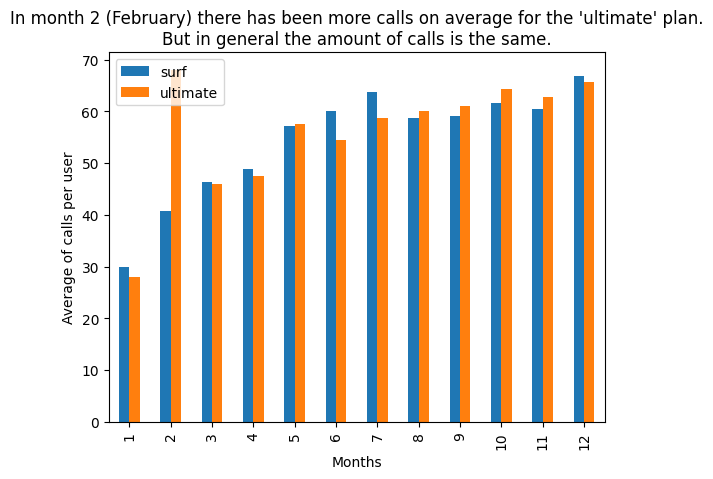

In [51]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

mask_surf = use_of_plan['plan']=='surf' #se usan en muchos lados estas máscaras, voy a guardarlas
mask_ultimate = use_of_plan['plan']=='ultimate'

plot = pd.concat([use_of_plan[mask_surf].groupby(['month'])['calls'].mean(),
          use_of_plan[mask_ultimate].groupby(['month'])['calls'].mean()],axis=1)
plot.columns = ['surf','ultimate']

plot.plot(kind='bar',title="In month 2 (February) there has been more calls on average for the 'ultimate' plan.\nBut in general the amount of calls is the same.",xlabel='Months',ylabel='Average of calls per user')

plt.show()

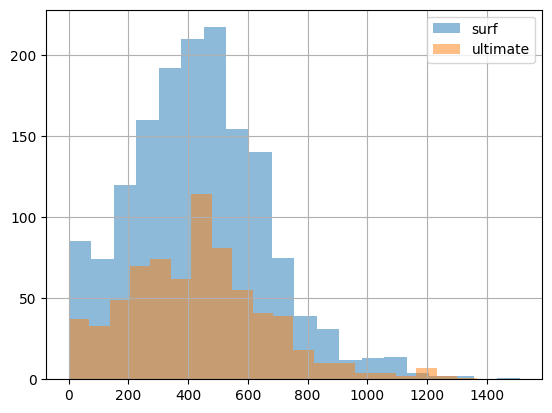

In [52]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

use_of_plan[mask_surf]['sum_duration'].hist(bins=20,alpha=0.5)
use_of_plan[mask_ultimate]['sum_duration'].hist(bins=20,alpha=0.5)

plt.legend(['surf','ultimate'])
plt.show()

Se ven muy parecidos los histogramas de los 2 planes

In [53]:
# Calcula la media y la varianza de la duración mensual de llamadas.

mean_surf = use_of_plan[mask_surf]['sum_duration'].mean()
mean_ultimate = use_of_plan[mask_ultimate]['sum_duration'].mean()

var_surf = np.var(use_of_plan[mask_surf]['sum_duration'])
var_ultimate = np.var(use_of_plan[mask_ultimate]['sum_duration'])

In [54]:
print(f"Surf:\n media minutos: {mean_surf}\n varianza: {var_surf}")
print(f"Ultimate:\n media minutos: {mean_ultimate}\n varianza: {var_ultimate}")

Surf:
 media minutos: 436.51974110032364
 varianza: 52537.03666530514
Ultimate:
 media minutos: 434.67601683029454
 varianza: 56494.28633925357


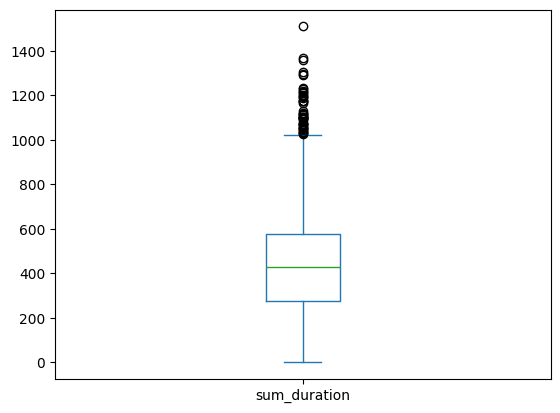

In [55]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

use_of_plan['sum_duration'].plot(kind='box')

plt.show()

Es muy parecido el comportamiento de ambos planes en cuestión de duración de las llamadas, con la mayoría de los datos entre 200 y 600 minutos mensuales

### Mensajes

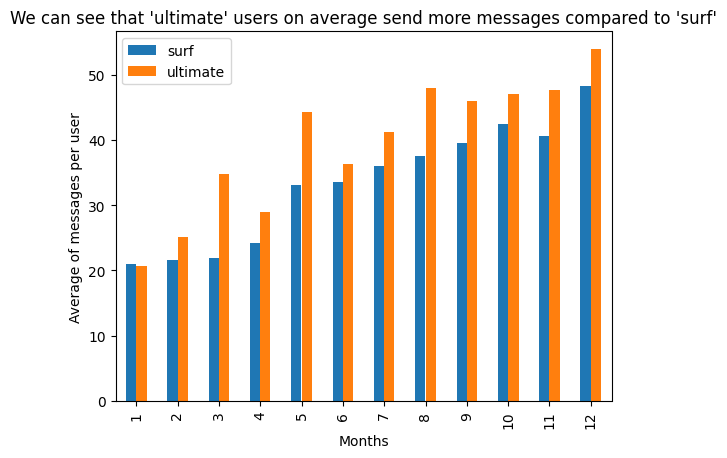

In [56]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

plot = pd.concat([use_of_plan[mask_surf].groupby(['month'])['messages'].mean(),
          use_of_plan[mask_ultimate].groupby(['month'])['messages'].mean()],axis=1)
plot.columns = ['surf','ultimate']

plot.plot(kind='bar',xlabel='Months',ylabel='Average of messages per user',title="We can see that 'ultimate' users on average send more messages compared to 'surf'")
plt.show()

In [57]:
mean_surf = use_of_plan[mask_surf]['messages'].mean()
mean_ultimate = use_of_plan[mask_ultimate]['messages'].mean()

var_surf = np.var(use_of_plan[mask_surf]['messages'])
var_ultimate = np.var(use_of_plan[mask_ultimate]['messages'])

print(f"Surf:\n media mensajes: {mean_surf}\n varianza: {var_surf}")
print(f"Ultimate:\n media mensajes: {mean_ultimate}\n varianza: {var_ultimate}")

Surf:
 media mensajes: 40.10965630114566
 varianza: 1090.4511506183685
Ultimate:
 media mensajes: 46.29623287671233
 varianza: 1083.3249173156314


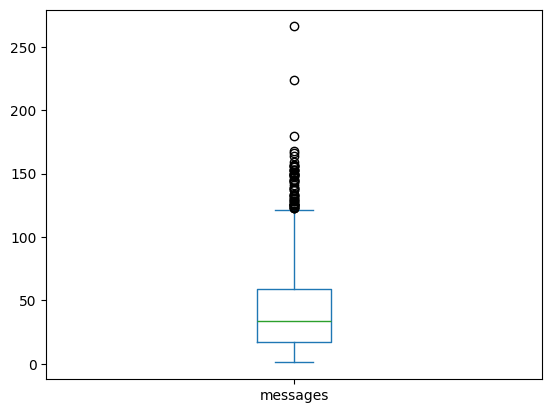

In [58]:
use_of_plan['messages'].plot(kind='box')

plt.show()

Los usuarios de `Ultimate` envían en promedio un poco más de mensajes que los usuarios de `Surf`, pero la diferencia es mínima, a lo mejor no sea suficiente como para decir que se comportan de manera distinta.

### Internet

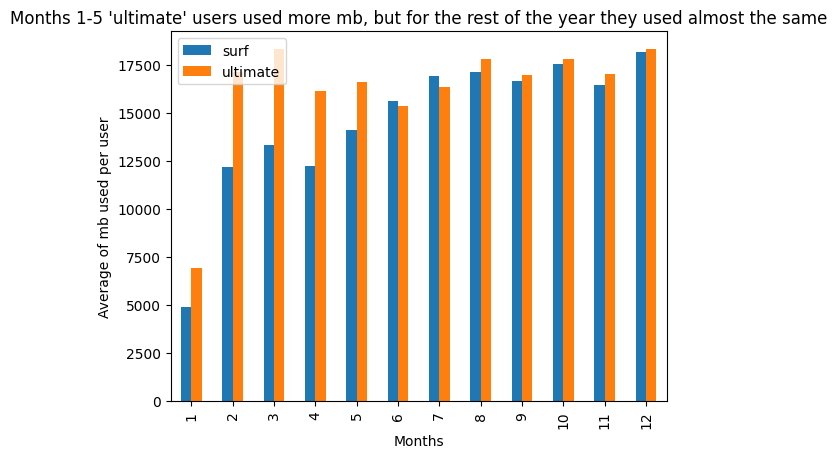

In [59]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

plot = pd.concat([use_of_plan[mask_surf].groupby(['month'])['mb_used'].mean(),
          use_of_plan[mask_ultimate].groupby(['month'])['mb_used'].mean()],axis=1)
plot.columns = ['surf','ultimate']

plot.plot(kind='bar',xlabel='Months',ylabel='Average of mb used per user',title="Months 1-5 'ultimate' users used more mb, but for the rest of the year they used almost the same")
plt.show()

In [60]:
mean_surf = use_of_plan[mask_surf]['mb_used'].mean()
mean_ultimate = use_of_plan[mask_ultimate]['mb_used'].mean()

var_surf = np.var(use_of_plan[mask_surf]['mb_used'])
var_ultimate = np.var(use_of_plan[mask_ultimate]['mb_used'])

print(f"Surf:\n media mb usados: {mean_surf}\n varianza: {var_surf}")
print(f"Ultimate:\n media mb usados: {mean_ultimate}\n varianza: {var_ultimate}")

Surf:
 media mb usados: 16717.702137355584
 varianza: 62128323.16300872
Ultimate:
 media mb usados: 17238.642253129346
 varianza: 61239556.12006475


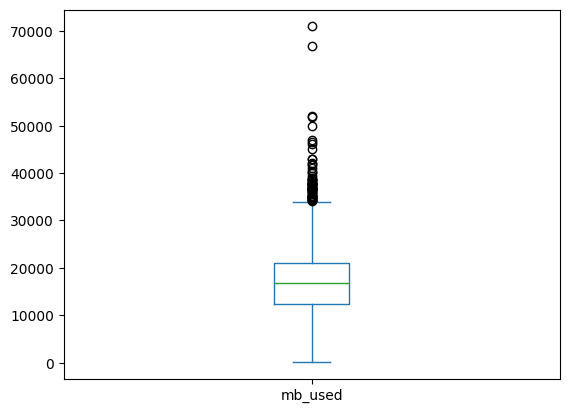

In [61]:
use_of_plan['mb_used'].plot(kind='box')

plt.show()

La mayoría de los usuarios usan entre 10 y 20 GB al mes, por las medias de `surf` y `ultimate` podemos ver que los usuarios de `ultimate` usan ligeramente más datos. También se aprecia eso en el `barplot`, pero sólo para los primeros meses. La diferencia podría no ser estadisticamente significativa.

## Ingreso

In [62]:
total_per_user_with_plan = pd.merge(total_per_user,df_users,how='left',left_index=True,right_on='user_id').loc[:,['total','plan']]

In [63]:
mask_surf = total_per_user_with_plan['plan'] == 'surf'
mask_ultimate = total_per_user_with_plan['plan'] == 'ultimate'

In [64]:
mean_surf = total_per_user_with_plan[mask_surf]['total'].mean()
mean_ultimate = total_per_user_with_plan[mask_ultimate]['total'].mean()

var_surf = np.var(total_per_user_with_plan[mask_surf]['total'])
var_ultimate = np.var(total_per_user_with_plan[mask_ultimate]['total'])

print(f"Surf:\n media de ingresos por usuario: {mean_surf}\n varianza: {var_surf}")
print(f"Ultimate:\n media de ingresos por usuario: {mean_ultimate}\n varianza: {var_ultimate}")

Surf:
 media de ingresos por usuario: 286.7603003003003
 varianza: 83966.11419210202
Ultimate:
 media de ingresos por usuario: 331.63057324840764
 varianza: 50044.55142196439


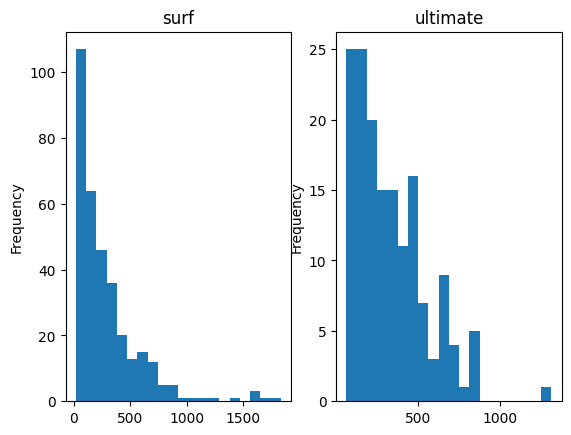

In [ ]:
plt.subplot(1,2,1)

total_per_user_with_plan[mask_surf]['total'].plot(kind='hist',title='surf',bins=20)

plt.subplot(1,2,2)
total_per_user_with_plan[mask_ultimate]['total'].plot(kind='hist',title='ultimate',bins=20)

plt.show()

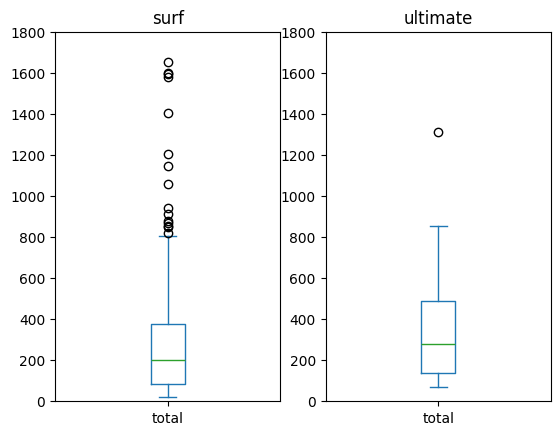

In [81]:
plt.subplot(1,2,1)

total_per_user_with_plan[mask_surf]['total'].plot(kind='box',title='surf',ylim=(0,1800))

plt.subplot(1,2,2)
total_per_user_with_plan[mask_ultimate]['total'].plot(kind='box',title='ultimate',ylim=(0,1800))

plt.show()

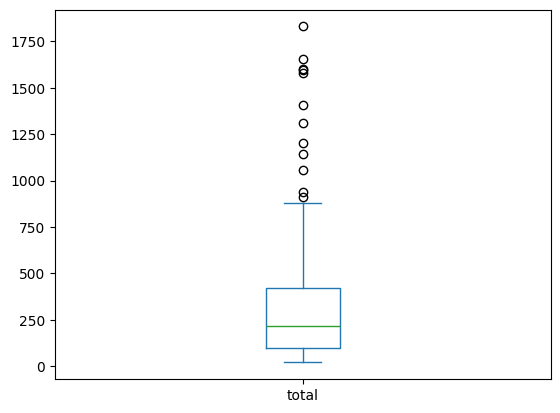

In [79]:
total_per_user_with_plan['total'].plot(kind='box')

plt.show()

La mayoría de los datos están entre 100 y 300 dólares de ingreso anual. La media de ingresos de `surf` es menor que la de `ultimate`.

## Prueba las hipótesis estadísticas

Hipótesis nula = Los ingresos son iguales

Hipótesis alternativa = Los ingresos son diferentes

alfa = 0.05 (equivocarnos en el 5% de los casos no representa perdidas significativas para la empresa)

prueba estadistica = ttest para 2 muestras independientes

In [84]:
import scipy.stats as st

In [85]:
# Prueba las hipótesis

surf = total_per_user_with_plan[mask_surf]['total']
ultimate = total_per_user_with_plan[mask_ultimate]['total']

results = st.ttest_ind(surf,ultimate)

results.pvalue

np.float64(0.08775764993343417)

Nuestra prueba nos dió un valor p de 8.7%, lo que significa que no podemos rechazar la hipótesis nula:

Hipótesis nula: los ingresos son iguales

=========================================================================================

Hipótesis nula = El ingreso del área NY-NJ es igual al resto

Hipótesis alternativa = El ingreso del área NY-NJ es diferente

alfa = 0.05

prueba estadistica = ttest para 2 muestras independientes

In [121]:
#Hasta ahorita no he necesitado información de regiones, tengo que asociar el área al usuario como lo hice con el plan, para luego hacer un filtro y tener ambos conjuntos.

total_per_user_with_area = pd.merge(total_per_user,df_users,how='left',left_index=True,right_on='user_id').loc[:,['total','city']]

In [124]:
ny_nj = total_per_user_with_area[total_per_user_with_area['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']
rest = total_per_user_with_area[~(total_per_user_with_area['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA')]

In [128]:
# Prueba las hipótesis

results = st.ttest_ind(ny_nj['total'],rest['total'])

results.pvalue

np.float64(0.5877641547620804)

Nuestro valor p es de 58%, lo cual significa que muy probablemente el área de `Nueva York-Nueva Jersey` se comporte de manera similar al resto, no podemos rechazar la hipótesis nula.

## Conclusión general

En conclusión, los clientes de `ultimate` y de `surf` no aportan ingresos lo suficientemente distintos como para poder decir con 95% de seguridad de que en verdad sean distintos (aunque se estuvo muy cerca de decir que sí)

Para la parte del análisis por área, `Nueva York-Nueva Jersey` se comporta muy parecido a como se comporta el resto de los datos tomados.